In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import cross_section, log_interpolate_1d

In [9]:
# Setup the colormap (Homeyer Rainbow from PyART)
def yuv_rainbow_24(nc):
    path1 = np.linspace(0.8*np.pi, 1.8*np.pi, nc)
    path2 = np.linspace(-0.33*np.pi, 0.33*np.pi, nc)

    y = np.concatenate([np.linspace(0.3, 0.85, nc*2//5),
                        np.linspace(0.9, 0.0, nc - nc*2//5)])
    u = 0.40*np.sin(path1)
    v = 0.55*np.sin(path2) + 0.1

    rgb_from_yuv = np.array([[1, 0, 1.13983],
                             [1, -0.39465, -0.58060],
                             [1, 2.03211, 0]])
    cmap_dict = {'blue': [], 'green': [], 'red': []}
    for i in range(len(y)):
        yuv = np.array([y[i], u[i], v[i]])
        rgb = rgb_from_yuv.dot(yuv)
        red_tuple = (i/(len(y)-1), rgb[0], rgb[0])
        green_tuple = (i/(len(y)-1), rgb[1], rgb[1])
        blue_tuple = (i/(len(y)-1), rgb[2], rgb[2])
        cmap_dict['blue'].append(blue_tuple)
        cmap_dict['red'].append(red_tuple)
        cmap_dict['green'].append(green_tuple)

    return cmap_dict

cmap = colors.LinearSegmentedColormap('homeyer_rainbow', yuv_rainbow_24(15), mpl.rcParams['image.lut'])

In [6]:
data = xr.open_dataset('wrf_for_metpy_demo.nc').metpy.parse_cf()

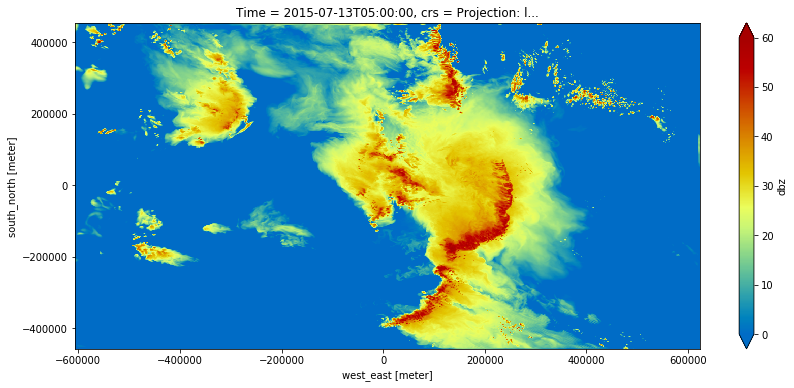

In [10]:
data['dbz'].max('bottom_top').plot(cmap=cmap, vmin=0, vmax=60, figsize=(14,6.), aspect='equal')

In [40]:
start_idx = (775, 180)
end_idx = (225, 1050)

start = tuple(np.asscalar(data[name][start_idx].values) for name in ('XLAT', 'XLONG'))
end = tuple(np.asscalar(data[name][end_idx].values) for name in ('XLAT', 'XLONG'))

start, end

((48.423492431640625, -99.77070617675781),
 (43.476261138916016, -88.48983764648438))

In [42]:
cross = cross_section(data, start, end, 1000)

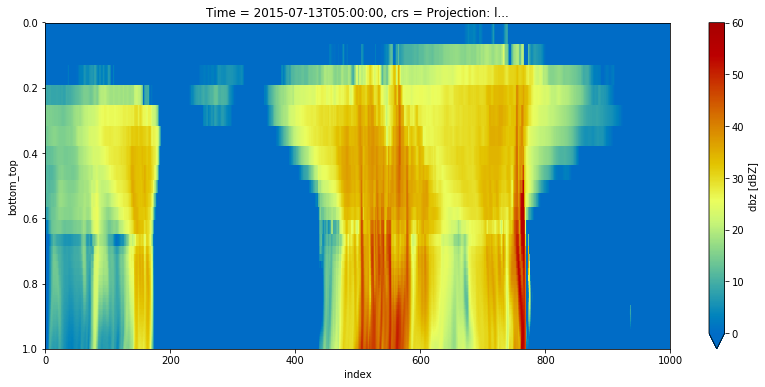

In [46]:
cross['dbz'].plot(cmap=cmap, vmin=0, vmax=60, figsize=(14,6.), aspect='equal')
plt.gca().invert_yaxis()
plt.show()

In [82]:
cross

<xarray.Dataset>
Dimensions:           (bottom_top: 49, index: 1000)
Coordinates:
    XLONG             (index) float64 -99.77 -99.76 -99.75 ... -88.5 -88.49
    XLAT              (index) float64 48.42 48.42 48.41 ... 43.49 43.48 43.48
    Time              datetime64[ns] 2015-07-13T05:00:00
  * bottom_top        (bottom_top) float32 0.9975 0.9925 0.987 ... 0.0965 0.0325
    crs               object Projection: lambert_conformal_conic
    west_east         (index) float64 -4.259e+05 -4.25e+05 ... 4.441e+05
    south_north       (index) float64 3.18e+05 3.175e+05 ... -2.32e+05
  * index             (index) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    height            (bottom_top, index) float64 517.0 517.5 ... 1.851e+04
    dbz               (bottom_top, index) float64 -7.406 -5.308 ... -30.0 -30.0
    pressure          (bottom_top, index) float64 945.2 945.1 ... 79.97 79.96
    terrain           (index) float64 496.5 496.9 496.9 ... 300.4 302.4 304.5
    ua     

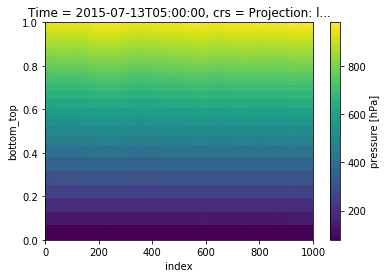

In [83]:
cross['pressure'].plot()

In [85]:
cross['pressure'].mean('index')

<xarray.DataArray 'pressure' (bottom_top: 49)>
array([964.040699, 959.416223, 954.332103, 949.249096, 944.628993, 940.007885,
       935.389352, 930.310863, 925.229853, 920.612781, 915.995554, 911.377745,
       906.760533, 901.683289, 896.605817, 891.99009 , 887.374886, 882.76067 ,
       877.685125, 872.609448, 867.99839 , 862.923626, 855.54482 , 846.324139,
       836.643815, 826.966549, 817.293802, 807.625144, 798.4211  , 788.761557,
       779.105775, 765.318853, 746.484728, 727.199583, 707.922962, 688.65063 ,
       660.214262, 622.161138, 584.123063, 546.101941, 508.100173, 470.117262,
       422.551891, 365.869448, 308.756587, 251.672604, 195.073964, 138.043156,
        79.655075])
Coordinates:
    Time        datetime64[ns] 2015-07-13T05:00:00
  * bottom_top  (bottom_top) float32 0.9975 0.9925 0.987 ... 0.0965 0.0325
    crs         object Projection: lambert_conformal_conic

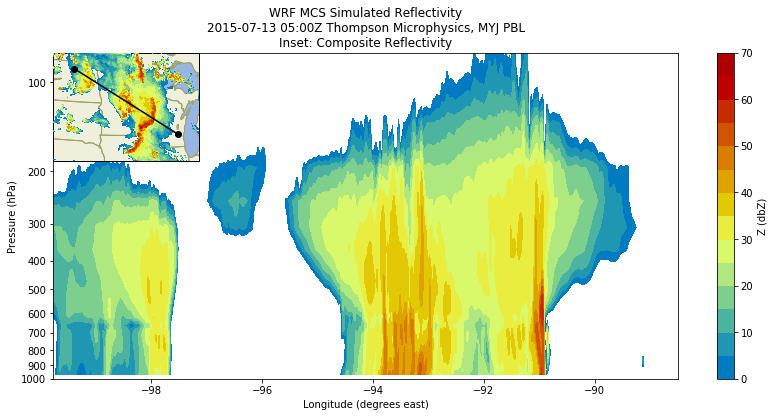

In [106]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(14., 6.))
ax = plt.axes()

pres_axis = cross['pressure'].mean('index')

# Plot refl using contourf
refl_contour = ax.contourf(cross['XLONG'], pres_axis, cross['dbz'],
                           levels=np.arange(0, 75, 5), cmap=cmap)
refl_colorbar = fig.colorbar(refl_contour)

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(pres_axis.max(), pres_axis.min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
data_crs = data['dbz'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.072, 0.63, 0.25, 0.25], projection=data_crs)

# Plot composite refl
ax_inset.contourf(data['west_east'], data['south_north'], data['dbz'].max('bottom_top'),
                  levels=np.arange(0, 75, 5), cmap=cmap, zorder=5)

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=10)
ax_inset.plot(cross['west_east'], cross['south_north'], c='k', zorder=10)

# Add geographic features
ax_inset.add_feature(cfeature.LAND.with_scale('50m'), facecolor=cfeature.COLORS['land'], zorder=1)
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='#9f9f68', zorder=2)
ax_inset.add_feature(cfeature.LAKES.with_scale('50m'), facecolor=cfeature.COLORS['water'],
               edgecolor='#9f9f68', zorder=2)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('WRF MCS Simulated Reflectivity\n'
             '2015-07-13 05:00Z Thompson Microphysics, MYJ PBL\n'
             'Inset: Composite Reflectivity')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
refl_colorbar.set_label('Z (dbZ)')

# plt.savefig('../poster/figures/basic_example_narr.pdf', bbox_inches='tight')
# plt.show()
plt.savefig('../poster/figures/wrf_refl.pdf', bbox_inches='tight')